# Instructions:
1. I have tested the two models, namely BERT embeddings + MLP and BERT embeddings + BiLSTM, in three datasets.

2. To run for a specific dataset, you can directly scroll to that particular data and run the code. For example, if you want to run for the YouTube dataset, you can start running from "2.YouTube Dataset".

3. To run the code, please upload form_spring_clean.csv, twitter_clean.csv and utube_clean.csv files provided under clean_data folder.

# 1.Form Spring Dataset


###1.1 Installing dependencies and importing packages

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt    

In [2]:
!pip install -q tensorflow-text

     |████████████████████████████████| 4.6 MB 8.4 MB/s 
     |████████████████████████████████| 511.7 MB 5.7 kB/s 
     |████████████████████████████████| 438 kB 50.2 MB/s 
     |████████████████████████████████| 1.6 MB 37.0 MB/s 
     |████████████████████████████████| 5.8 MB 42.7 MB/s 


In [3]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.1 MB 5.4 MB/s 
     |████████████████████████████████| 43 kB 1.1 MB/s 
     |████████████████████████████████| 636 kB 39.8 MB/s 
     |████████████████████████████████| 116 kB 15.9 MB/s 
     |████████████████████████████████| 1.1 MB 33.3 MB/s 
     |████████████████████████████████| 352 kB 21.4 MB/s 
     |████████████████████████████████| 238 kB 32.1 MB/s 
     |████████████████████████████████| 99 kB 9.0 MB/s 
     |████████████████████████████████| 1.3 MB 33.8 MB/s 


In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.6 MB/s 
     |████████████████████████████████| 6.6 MB 41.0 MB/s 
     |████████████████████████████████| 101 kB 11.3 MB/s 


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

np.set_printoptions(suppress=True)
print(tf.__version__)

import shutil

from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

2.9.1


##1.2 Reading and preparing the dataset

In [6]:
df_form=pd.read_csv('form_spring_clean.csv')

In [7]:
df_form

,Text,hate_words,Label,Text_clean,hate_words_clean,category
0,Q: what&#039;s your favorite song? :D<br>A: I ...,0,0,q what039s favorite song d a i like many songs...,0,non_hate_speech
1,Q: <3<br>A: </3 ? haha jk! <33,0,0,q 3 a 3 haha jk 33,0,non_hate_speech
2,Q: &quot;hey angel you duh sexy&quot;<br>A: R...,0,0,q quothey angel duh sexyquot a really thanks haha,0,non_hate_speech
3,Q: (:<br>A: ;(,0,0,q a,0,non_hate_speech
4,Q: ******************MEOWWW*******************...,0,0,q meowww a rawr,0,non_hate_speech
...,...,...,...,...,...,...
17022,Q: Youu2019re awesome :] Give yourself a compl...,0,0,q youu2019re awesome give compliment deserve a...,0,non_hate_speech
17023,Q: Yu play with yurself ?<br>A: all the time. ...,0,0,q yu play yurself a time sometimes day,0,non_hate_speech
17024,Q: yukk beer is disgusting. i can only drink i...,0,0,q yukk beer disgusting drink i039m already dru...,0,non_hate_speech
17025,Q: if i told u den it would make it all the le...,fake scaredyy cat,1,q told u den would make less fun a would make ...,fake scaredyy cat,hate_speech


In [8]:
# Grouping data by label
df_form.groupby('Label').count()

,Text,hate_words,Text_clean,hate_words_clean,category
Label,,,,,
0,13616,13616,13616,13507,13616
1,3411,3411,3411,3335,3411


This is an unbalanced dataset. 

In [9]:
df_form['category'].value_counts()

non_hate_speech    13616
hate_speech         3411
Name: category, dtype: int64

###1.2.1 Splitting the data between train, validation and test sets:

In [10]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df_form.index.values,
    df_form.Label.values,
    test_size=0.10,
    random_state=42,
    stratify=df_form.Label.values,    
)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    df_form.loc[X_train_].index.values,
    df_form.loc[X_train_].Label.values,
    test_size=0.10,
    random_state=42,
    stratify=df_form.loc[X_train_].Label.values,  
)

In [12]:
df_form['data_type'] = ['not_set']*df_form.shape[0]
df_form.loc[X_train, 'data_type'] = 'train'
df_form.loc[X_val, 'data_type'] = 'val'
df_form.loc[X_test, 'data_type'] = 'test'

In [13]:
df_form.groupby(['category', 'Label', 'data_type']).count()

Text  hate_words  Text_clean  \
category        Label data_type                                  
hate_speech     1     test         341         341         341   
                      train       2763        2763        2763   
                      val          307         307         307   
non_hate_speech 0     test        1362        1362        1362   
                      train      11028       11028       11028   
                      val         1226        1226        1226   

                                 hate_words_clean  
category        Label data_type                    
hate_speech     1     test                    336  
                      train                  2700  
                      val                     299  
non_hate_speech 0     test                   1351  
                      train                 10941  
                      val                    1215

In [14]:
df_train = df_form.loc[df_form["data_type"]=="train"]
df_train.head(5)

,Text,hate_words,Label,Text_clean,hate_words_clean,category,data_type
0,Q: what&#039;s your favorite song? :D<br>A: I ...,0,0,q what039s favorite song d a i like many songs...,0,non_hate_speech,train
1,Q: <3<br>A: </3 ? haha jk! <33,0,0,q 3 a 3 haha jk 33,0,non_hate_speech,train
2,Q: &quot;hey angel you duh sexy&quot;<br>A: R...,0,0,q quothey angel duh sexyquot a really thanks haha,0,non_hate_speech,train
3,Q: (:<br>A: ;(,0,0,q a,0,non_hate_speech,train
6,Q: Apriiiiiiiiiiiill!!! I miss uuuu! It&#039;s...,0,0,q apriiiiiiiiiiiill i miss uuuu it039s emma bt...,0,non_hate_speech,train


In [15]:
df_val = df_form.loc[df_form["data_type"]=="val"]
df_val.head(5)

,Text,hate_words,Label,Text_clean,hate_words_clean,category,data_type
60,Q: have you ever been on itellyouthat.com? go ...,0,0,q ever itellyouthat com go tell something worl...,0,non_hate_speech,val
75,Q: heyyyyyy!!! how u doin!!!!!<br>A: Im doing ...,0,0,q heyyyyyy u doin a im good thankyuh heyyy hbu,0,non_hate_speech,val
83,Q: i love youu chica!<33<br>A: NO no no! I Lov...,0,0,q love youu chica 33 a no i love youuu moreee3...,0,non_hate_speech,val
106,Q: If you could make one person fall in love w...,0,0,q if could make one person fall love would a m...,0,non_hate_speech,val
112,Q: If you had to cook dinner for someone tonig...,0,0,q if cook dinner someone tonight would make a ...,0,non_hate_speech,val


In [16]:
df_test = df_form.loc[df_form["data_type"]=="test"]
df_test.head(5)

,Text,hate_words,Label,Text_clean,hate_words_clean,category,data_type
4,Q: ******************MEOWWW*******************...,0,0,q meowww a rawr,0,non_hate_speech,test
5,Q: any makeup tips? i suck at doing my makeup ...,0,0,q makeup tips suck makeup lol a sure like tell...,0,non_hate_speech,test
9,Q: are you a trusting person?<br>A: Yes veryy ...,0,0,q trusting person a yes veryy trustin person m...,0,non_hate_speech,test
17,Q: Bitch u thee bomb like Tick TICK!<br>A: Hah...,Bitch u thee bomb like Tick TICK,1,q bitch u thee bomb like tick tick a hahah thanks,bitch u thee bomb like tick tick,hate_speech,test
64,Q: Hello bitch! How&#039;s ur day going? Good ...,0,0,q hello bitch how039s ur day going good i hope...,0,non_hate_speech,test


In [17]:
df_form.dtypes

Text                object
hate_words          object
Label                int64
Text_clean          object
hate_words_clean    object
category            object
data_type           object
dtype: object

##1.3 Build TensorFlow input 

In [18]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.Text_clean.values, df_train.Label.values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.Text_clean.values, df_val.Label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.Text_clean.values, df_test.Label.values))

In [19]:
train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [21]:
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [22]:
for feat, targ in train_ds.take(1):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [b'q this one time i walking park magpie attacked lol have ever attacked bird have ever attacked anything dog cat etcetera etcetera a nope havent attacked anything sister lol count hmm hope'
 b'q how morning going far a well seen begun think maybe busy see s'
 b'q tabi people talking shit formspring anonymously need grow pair if they39re gonna hate anonymously obviously life grow stop trying start shit internet i love tabi a d awhhh thankyou best r loveyoutod'
 b'q person obviously paparazzichina a hahahaha'
 b'q desbribe romantic kiss you039ve ever a wife i first kiss hot tub moon shining stars she pretty'
 b'q who asked many times fucked a anonymous yo r eh whatever big deal'
 b'q hey cutie r yu qot ceeeell a yea want'
 b'q i039m good missed 3 x a ive missed you so much'
 b'q waht was thee last thing yu kleaned a oh haha dishes lol'
 b'q luvv mi booo3333 a ily2 boothang'
 b'q no im but thanks throwing a uhh sound like retard say shit like cause dont know whats gonna happen 

##1.4 Loading models from TensorFlow Hub

In [23]:
tfhub_handle_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3",trainable=True)
tfhub_handle_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1")


print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model selected: {tfhub_handle_preprocess}')


BERT model selected           : <tensorflow_hub.keras_layer.KerasLayer object at 0x7f88f8f84bd0>
Preprocess model selected: <tensorflow_hub.keras_layer.KerasLayer object at 0x7f88f8f84c50>


###1.4.1 The preprocessing model

It is to be noted that before we feed input to BERT the text format should be in numeric format. TensorFlow Hub provides a matching preprocessing model for each of the BERT models, which implements this transformation using TF ops from the TF.text library. Hence, It is not necessary to run pure Python code outside the TensorFlow model to preprocess text.

In [24]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_encoder)

Let's try the preprocessing model on some text and see the output:

In [25]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    text = text_batch.numpy()[i]
    print(f'Text: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

text_test = ['this is such an amazing movie!']
text_test = [text]


text_preprocessed = tfhub_handle_preprocess(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Text: b'q does austin big small dick a dont ask'
Label : 1
Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1053 2515 5899 2502 2235 5980 1037 2123 2102 3198  102]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: <tensorflow_hub.keras_layer.KerasLayer object at 0x7f87d06d5550>
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.83791566 -0.31952596 -0.52429515  0.7546734   0.5013779  -0.09763784
  0.81348765  0.1403538  -0.4414879  -0.99994415 -0.17318475  0.8334168 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.0827524   0.32878953 -0.15304893 ... -0.49290884  0.3560132
   0.30004647]
 [ 0.41827923  0.8757301   0.64697164 ... -0.63469315  0.37955672
   0.3036539 ]
 [ 0.40852284  0.7919631   0.62284833 ... -0.11308985  0.3851412
   0.1246378 ]
 ...
 [ 0.20416808  0.65504247  0.05966849 ... -0.64130664 -0.04359407
  -0.3394336 ]
 [ 0.08387975  0.3478825   0.10910858 ... -1.1498768  -0.21347553
  -0.22636104]
 [-0.18111764  0.95278233 -0.0469778  ... -0.5644958   0.40261525
   0.75622106]]


##1.5 Techniques to deal with unbalanced data

###1.5.1 Calculate class weights

Since our datset is higly imbalanced there are high chances our model will be biased toward majority class. Now since I want my model to concentrate more on minority class which I can achieve by passing more weights to minority class.


In [ ]:
df_form

,Text,hate_words,Label,Text_clean,hate_words_clean,category,data_type
0,Q: what&#039;s your favorite song? :D<br>A: I ...,0,0,q what039s favorite song d a i like many songs...,0,non_hate_speech,train
1,Q: <3<br>A: </3 ? haha jk! <33,0,0,q 3 a 3 haha jk 33,0,non_hate_speech,train
2,Q: &quot;hey angel you duh sexy&quot;<br>A: R...,0,0,q quothey angel duh sexyquot a really thanks haha,0,non_hate_speech,train
3,Q: (:<br>A: ;(,0,0,q a,0,non_hate_speech,train
4,Q: ******************MEOWWW*******************...,0,0,q meowww a rawr,0,non_hate_speech,test
...,...,...,...,...,...,...,...
17022,Q: Youu2019re awesome :] Give yourself a compl...,0,0,q youu2019re awesome give compliment deserve a...,0,non_hate_speech,train
17023,Q: Yu play with yurself ?<br>A: all the time. ...,0,0,q yu play yurself a time sometimes day,0,non_hate_speech,train
17024,Q: yukk beer is disgusting. i can only drink i...,0,0,q yukk beer disgusting drink i039m already dru...,0,non_hate_speech,train
17025,Q: if i told u den it would make it all the le...,fake scaredyy cat,1,q told u den would make less fun a would make ...,fake scaredyy cat,hate_speech,test


In [26]:
non_hate_speech, hate_speech = np.bincount(df_form['Label'])
total = hate_speech + non_hate_speech
print('Examples:\n    Total: {}\n    non_hate_speech: {} ({:.2f}% of total)\n'.format(
    total, non_hate_speech, 100 *  non_hate_speech / total))
print('Examples:\n    Total: {}\n    hate_speech: {} ({:.2f}% of total)\n'.format(
    total, hate_speech, 100 * hate_speech / total))


Examples:
    Total: 17027
    non_hate_speech: 13616 (79.97% of total)

Examples:
    Total: 17027
    hate_speech: 3411 (20.03% of total)



In [27]:
weight_for_0 = (1 / non_hate_speech)*(total)/2.0 
weight_for_1 = (1 / hate_speech)*(total)/2.0


class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.63
Weight for class 1: 2.50


In [ ]:
class_weights

{0: 0.6252570505287897, 1: 2.4958956317795367}

###1.5.2 Set the correct initial bias


In [29]:
initial_output_bias = np.array([3.938462]) #random
initial_output_bias 

array([3.938462])

In [28]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3",trainable=True)

In [30]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.5132725 , -0.88845736, ..., -0.7474887 ,
        -0.75314736,  0.91964495],
       [-0.8720836 , -0.50543964, -0.94446665, ..., -0.858475  ,
        -0.7174535 ,  0.88082975]], dtype=float32)>

##1.6 BERT + MLP


I am going to create a simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

In [ ]:
def build_classifier_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
       
        
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(1, activation="sigmoid", name='classifier', bias_initializer=output_bias)(net)
    
    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model(output_bias=initial_output_bias)
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.7273557]], shape=(1, 1), dtype=float32)


In [ ]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

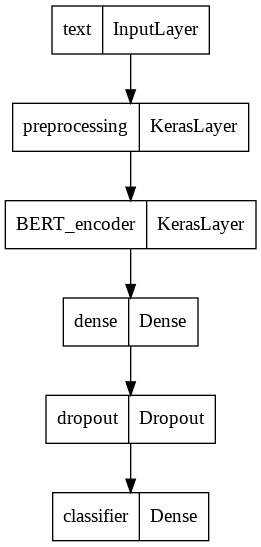

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("form_bert_mlp",
                             monitor="val_TP",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

In [ ]:
earlystop = EarlyStopping(monitor = 'val_TP', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 2, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

In [ ]:
METRICS = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.TruePositives(name='TP')
]

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks = callbacks,
                               class_weight=class_weights
)

Training model with <tensorflow_hub.keras_layer.KerasLayer object at 0x7f87d06d5550>
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


431/431 [==============================] - ETA: 0s - loss: 0.7315 - precision: 0.3079 - recall: 0.6869 - TP: 1898.0000
Epoch 1: val_TP improved from -inf to 150.00000, saving model to form_bert_mlp


431/431 [==============================] - 289s 628ms/step - loss: 0.7315 - precision: 0.3079 - recall: 0.6869 - TP: 1898.0000 - val_loss: 0.4792 - val_precision: 0.6881 - val_recall: 0.4886 - val_TP: 150.0000
Epoch 2/10
431/431 [==============================] - ETA: 0s - loss: 0.4983 - precision: 0.5033 - recall: 0.7275 - TP: 2010.0000
Epoch 2: val_TP improved from 150.00000 to 227.00000, saving model to form_bert_mlp


431/431 [==============================] - 268s 622ms/step - loss: 0.4983 - precision: 0.5033 - recall: 0.7275 - TP: 2010.0000 - val_loss: 0.4883 - val_precision: 0.4809 - val_recall: 0.7394 - val_TP: 227.0000
Epoch 3/10
431/431 [==============================] - ETA: 0s - loss: 0.4208 - precision: 0.5575 - recall: 0.8067 - TP: 2229.0000Restoring model weights from the end of the best epoch: 1.

Epoch 3: val_TP improved from 227.00000 to 229.00000, saving model to form_bert_mlp


431/431 [==============================] - 268s 621ms/step - loss: 0.4208 - precision: 0.5575 - recall: 0.8067 - TP: 2229.0000 - val_loss: 0.5377 - val_precision: 0.4412 - val_recall: 0.7459 - val_TP: 229.0000
Epoch 3: early stopping


dict_keys(['loss', 'precision', 'recall', 'TP', 'val_loss', 'val_precision', 'val_recall', 'val_TP'])


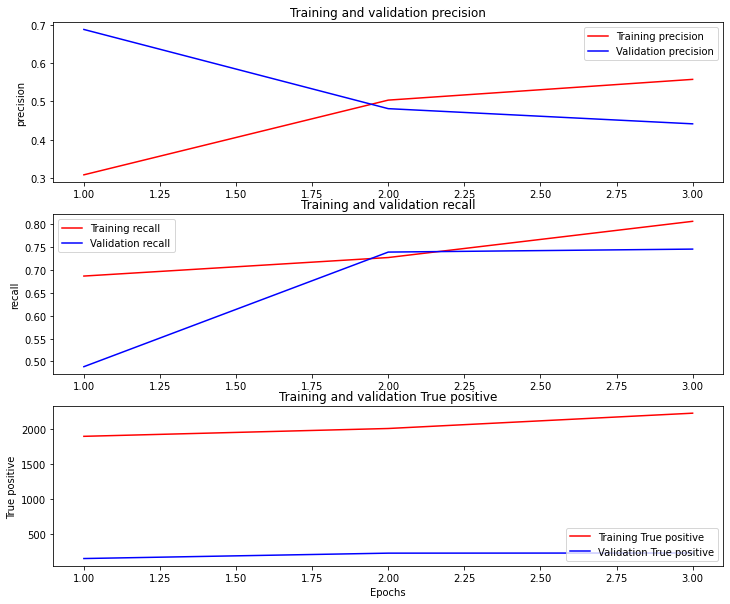

In [ ]:
history_dict = history.history
print(history_dict.keys())

TP = history_dict['TP']
val_TP = history_dict['val_TP']
precision = history_dict['precision']
val_precision = history_dict['val_precision']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

epochs = range(1, len(TP) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(3, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, precision, 'r', label='Training precision')
# b is for "solid blue line"
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
# plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()

plt.subplot(3, 1, 2)
# "bo" is for "blue dot"
plt.plot(epochs, recall, 'r', label='Training recall')
# b is for "solid blue line"
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
# plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(epochs, TP, 'r', label='Training True positive')
plt.plot(epochs, val_TP, 'b', label='Validation True positive')
plt.title('Training and validation True positive')
plt.xlabel('Epochs')
plt.ylabel('True positive')
plt.legend(loc='lower right')

In [ ]:
history_dict

{'TP': [1898.0, 2010.0, 2229.0],
 'loss': [0.73145592212677, 0.4983330965042114, 0.42075639963150024],
 'precision': [0.30786699056625366, 0.5032548904418945, 0.5575287938117981],
 'recall': [0.6869344711303711, 0.7274701595306396, 0.8067318201065063],
 'val_TP': [150.0, 227.0, 229.0],
 'val_loss': [0.47921085357666016, 0.4883083999156952, 0.5377193093299866],
 'val_precision': [0.6880733966827393,
  0.48093220591545105,
  0.4412331283092499],
 'val_recall': [0.48859935998916626, 0.7394136786460876, 0.7459283471107483]}

In [ ]:
from keras.models import load_model

classifier_model = tf.keras.models.load_model(
       ('form_bert_mlp'),
       custom_objects={'KerasLayer': hub.KerasLayer,'AdamWeightDecay': optimizer}
)

###1.6.1 Results for MLP

####1.6.1.1 Doing predictions

In [ ]:
y_pred=classifier_model.predict(test_ds)

54/54 [==============================] - 12s 211ms/step


In [ ]:
y_pred_mod=[]
for i in y_pred.tolist():
  for k in i:
    y_pred_mod.append(k)

In [ ]:
for i in range(len(y_pred_mod)):
  if y_pred_mod[i] <= float(0.5):
    y_pred_mod[i]= 0
  else:
    y_pred_mod[i]=1

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
result=precision_recall_fscore_support(y_test, y_pred_mod, average='macro')
print('Precision for BERT embeddings + MLP in FormSpring Dataset is:',round(result[0],3))
print('Recall for BERT embeddings + MLP in FormSpring Dataset is:',round(result[1],3))
print('macro F1 score for BERT embeddings + MLP in FormSpring Dataset is:',round(result[2],3))

Precision for BERT embeddings + MLP in FormSpring Dataset is: 0.479
Recall for BERT embeddings + MLP in FormSpring Dataset is: 0.484
macro F1 score for BERT embeddings + MLP in FormSpring Dataset is: 0.479


In [ ]:
from sklearn.metrics import f1_score
print("macro F1 score for BERT embeddings + MLP is:",f1_score(y_test, y_pred_mod, average='macro'))

macro F1 score for BERT embeddings + MLP is: 0.4791947807345417


###1.6.2 Confusion Matrix MLP

In [ ]:
def matrix_per(cf_matrix):
  group_percentages_list=[]
  k=cf_matrix.flatten()
  for i in range(0,len(cf_matrix.flatten())):
    if i == 0 or i == 1:
      group_percentages_list.append(k[i]/(k[0] + k[1]))
    else:
      group_percentages_list.append(k[i]/(k[2] + k[3]))
  return group_percentages_list

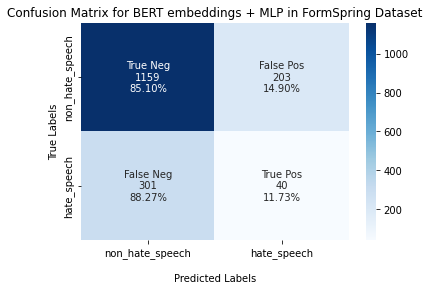

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf_matrix=confusion_matrix(y_test, y_pred_mod)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     matrix_per(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix for BERT embeddings + MLP in FormSpring Dataset');
ax.set_xlabel('\nPredicted Labels')
ax.set_ylabel('True Labels');

ax.xaxis.set_ticklabels(['non_hate_speech','hate_speech'])
ax.yaxis.set_ticklabels(['non_hate_speech','hate_speech'])

## Display the visualization of the Confusion Matrix.
plt.show()

##1.7 BERT + BiLSTM

In [31]:
from tensorflow.keras.layers import Bidirectional
from keras.layers import LSTM
def build_BiLstm_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    #net = outputs['pooled_output'] # [batch_size, 768].
    net = sequence_output = outputs["sequence_output"] # [batch_size, seq_length, 768]
    net=Bidirectional(LSTM(units=100,activation='tanh',return_sequences=False))(net)
      
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    
    net = tf.keras.layers.Dropout(0.1)(net)
#   net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.Dense(1, activation="sigmoid", name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

For the implementation with BiLSTM, I am using the sequence_output as input. It represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the text. I belive that this outputs saves positional information about the inputs, then it would make more sense to feed a BiLSTM layer.

In [32]:
bi_classifier_model = build_BiLstm_classifier_model()
bert_raw_result = bi_classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.61296064]], shape=(1, 1), dtype=float32)


In [33]:
text_test

[b'q does austin big small dick a dont ask']

In [ ]:
bi_classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

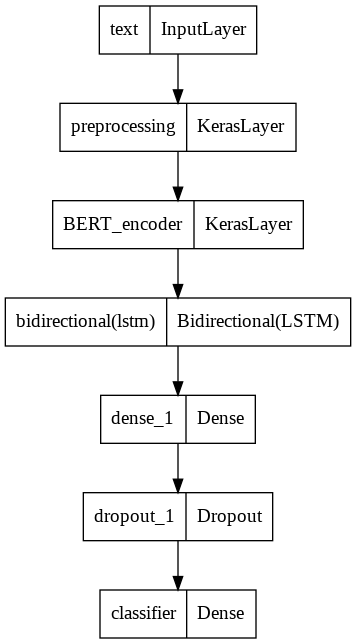

In [ ]:
tf.keras.utils.plot_model(bi_classifier_model)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("form_bert_bi",
                             monitor="val_TP",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

In [ ]:
earlystop = EarlyStopping(monitor = 'val_TP', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 2, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

In [ ]:
METRICS = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.TruePositives(name='TP')
]

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
bi_classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history_cnn = bi_classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks = callbacks,
                               class_weight=class_weights
)

Training model with <tensorflow_hub.keras_layer.KerasLayer object at 0x7f87d06d5550>
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


431/431 [==============================] - ETA: 0s - loss: 0.5149 - precision: 0.4933 - recall: 0.6775 - TP: 1872.0000
Epoch 1: val_TP improved from -inf to 218.00000, saving model to form_bert_bi


431/431 [==============================] - 309s 682ms/step - loss: 0.5149 - precision: 0.4933 - recall: 0.6775 - TP: 1872.0000 - val_loss: 0.4682 - val_precision: 0.4966 - val_recall: 0.7101 - val_TP: 218.0000
Epoch 2/10
431/431 [==============================] - ETA: 0s - loss: 0.4508 - precision: 0.5462 - recall: 0.7702 - TP: 2128.0000
Epoch 2: val_TP did not improve from 218.00000
431/431 [==============================] - 256s 594ms/step - loss: 0.4508 - precision: 0.5462 - recall: 0.7702 - TP: 2128.0000 - val_loss: 0.4405 - val_precision: 0.5367 - val_recall: 0.6906 - val_TP: 212.0000
Epoch 3/10
431/431 [==============================] - ETA: 0s - loss: 0.3800 - precision: 0.5917 - recall: 0.8335 - TP: 2303.0000
Epoch 3: val_TP did not improve from 218.00000
431/431 [==============================] - 256s 594ms/step - loss: 0.3800 - precision: 0.5917 - recall: 0.8335 - TP: 2303.0000 - val_loss: 0.5208 - val_precision: 0.4540 - val_recall: 0.7068 - val_TP: 217.0000
Epoch 4/10
431/4

dict_keys(['loss', 'precision', 'recall', 'TP', 'val_loss', 'val_precision', 'val_recall', 'val_TP'])


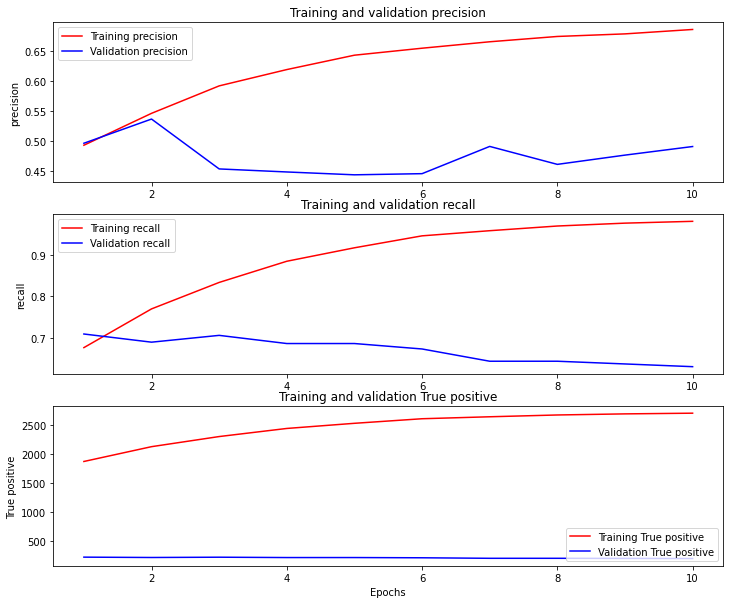

In [ ]:
history_dict = history_cnn.history
print(history_dict.keys())

TP = history_dict['TP']
val_TP = history_dict['val_TP']
precision = history_dict['precision']
val_precision = history_dict['val_precision']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

epochs = range(1, len(TP) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(3, 1, 1)
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.ylabel('precision')
plt.legend()

plt.subplot(3, 1, 2)
# "bo" is for "blue dot"
plt.plot(epochs, recall, 'r', label='Training recall')
# b is for "solid blue line"
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
#plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(epochs, TP, 'r', label='Training True positive')
plt.plot(epochs, val_TP, 'b', label='Validation True positive')
plt.title('Training and validation True positive')
plt.xlabel('Epochs')
plt.ylabel('True positive')
plt.legend(loc='lower right')

In [ ]:
history_dict

{'TP': [1872.0,
  2128.0,
  2303.0,
  2443.0,
  2532.0,
  2611.0,
  2645.0,
  2676.0,
  2695.0,
  2707.0],
 'loss': [0.5148555040359497,
  0.45084547996520996,
  0.38001978397369385,
  0.3279850482940674,
  0.2853834629058838,
  0.253680020570755,
  0.23390914499759674,
  0.21071520447731018,
  0.20125409960746765,
  0.18730978667736053],
 'precision': [0.4932806193828583,
  0.546201229095459,
  0.5917266011238098,
  0.618794322013855,
  0.6426395773887634,
  0.6542220115661621,
  0.6649069786071777,
  0.6737160086631775,
  0.6779873967170715,
  0.6853164434432983],
 'recall': [0.6775244474411011,
  0.7701773643493652,
  0.8335142731666565,
  0.8841838836669922,
  0.9163952469825745,
  0.9449873566627502,
  0.9572927951812744,
  0.9685124754905701,
  0.9753890633583069,
  0.9797321557998657],
 'val_TP': [218.0,
  212.0,
  217.0,
  211.0,
  211.0,
  207.0,
  198.0,
  198.0,
  196.0,
  194.0],
 'val_loss': [0.4682127833366394,
  0.44048774242401123,
  0.5207672119140625,
  0.542580544948

In [ ]:
from keras.models import load_model

bi_classifier_model = tf.keras.models.load_model(
       ('form_bert_bi'),
       custom_objects={'KerasLayer': hub.KerasLayer,'AdamWeightDecay': optimizer}
)

###1.7.1 Results for BiLSTM

####1.7.1.1 Doing predictions

In [ ]:
y_pred=bi_classifier_model.predict(test_ds)

54/54 [==============================] - 13s 213ms/step


In [ ]:
y_pred_mod=[]
for i in y_pred.tolist():
  for k in i:
    y_pred_mod.append(k)

In [ ]:
for i in range(len(y_pred_mod)):
  if y_pred_mod[i] <= float(0.5):
    y_pred_mod[i]= 0
  else:
    y_pred_mod[i]=1

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
result=precision_recall_fscore_support(y_test, y_pred_mod, average='macro')
print('Precision for BERT embeddings + BiLSTM in FormSpring Dataset is:',round(result[0],3))
print('Recall for BERT embeddings + BiLSTM in FormSpring Dataset is:',round(result[1],3))
print('macro F1 score for BERT embeddings + BiLSTM in FormSpring Dataset is:',round(result[2],3))

Precision for BERT embeddings + BiLSTM in FormSpring Dataset is: 0.473
Recall for BERT embeddings + BiLSTM in FormSpring Dataset is: 0.469
macro F1 score for BERT embeddings + BiLSTM in FormSpring Dataset is: 0.47


In [ ]:
from sklearn.metrics import f1_score
print("macro F1 score for BERT embeddings + BiLSTM is:",f1_score(y_test, y_pred_mod, average='macro'))

macro F1 score for BERT embeddings + BiLSTM is: 0.46956573824498354


###1.7.2 Confusion Matrix BiLSTM

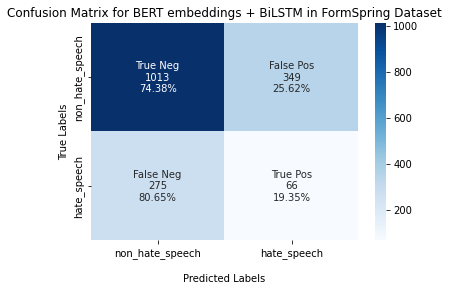

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf_matrix=confusion_matrix(y_test, y_pred_mod)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     matrix_per(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix for BERT embeddings + BiLSTM in FormSpring Dataset');
ax.set_xlabel('\nPredicted Labels')
ax.set_ylabel('True Labels');

ax.xaxis.set_ticklabels(['non_hate_speech','hate_speech'])
ax.yaxis.set_ticklabels(['non_hate_speech','hate_speech'])

## Display the visualization of the Confusion Matrix.
plt.show()

# 2.YouTube Dataset 

##2.1 Installing dependencies and importing packages

In [34]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt    

In [35]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

In [36]:
!pip install -q tf-models-official

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 3.1 MB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 
     |████████████████████████████████| 6.6 MB 57.2 MB/s 


In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

np.set_printoptions(suppress=True)
print(tf.__version__)

import shutil

from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

2.9.1


##2.2 Reading and preparing the dataset

In [38]:
df_utube=pd.read_csv('utube_clean.csv')

In [39]:
df_utube

,Text,hate_words,Label,Text_clean,hate_words_clean,category
0,Does N.e.bodyelse Hear her Crazy ass Screamin ...,0,0,does n e bodyelse hear crazy ass screamin hoe ...,0,non_hate_speech
1,There are so many things that are incorrect wi...,0,0,there many things incorrect comment unbelievab...,0,non_hate_speech
2,3:26 hahah my boyfriend showed this song to me...,0,0,326 hahah boyfriend showed song i love me tooo...,0,non_hate_speech
3,dick beyonce fuck y a ass hole you are truely ...,"""""dick beyonce fuck y a ass hole you are truel...",1,dick beyonce fuck ass hole truely dog bitch ph...,dick beyonce fuck ass hole truely dog bitch ma...,hate_speech
4,DongHaeTaemin and Kai ;A; luhansehun and bacon...,0,0,donghaetaemin kai a luhansehun bacon xd taemin...,0,non_hate_speech
...,...,...,...,...,...,...
3455,She pretty I love this song I miss the old kel...,0,0,she pretty i love song i miss old kelly ok rih...,0,non_hate_speech
3456,Status-Online Im ZxkillergirlzX! I'm Zxkillerg...,0,0,statusonline im zxkillergirlzx im zxkillergirl...,0,non_hate_speech
3457,JR so cute EXO M Better I agree like yeah yeah...,0,0,jr cute exo m better i agree like yeah yeah ye...,0,non_hate_speech
3458,! !,0,0,NaN,0,non_hate_speech


In [40]:
# Grouping data by label
df_utube.groupby('Label').count()

,Text,hate_words,Text_clean,hate_words_clean,category
Label,,,,,
0,3144,3144,3139,3144,3144
1,316,316,316,316,316


This is an imbalanced dataset. 

In [41]:
df_utube['category'].value_counts()

non_hate_speech    3144
hate_speech         316
Name: category, dtype: int64

###2.2.1 Splitting the data between train, validation and test sets:

In [42]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df_utube.index.values,
    df_utube.Label.values,
    test_size=0.10,
    random_state=42,
    stratify=df_utube.Label.values,    
)

In [43]:
X_train, X_val, y_train, y_val = train_test_split(
    df_utube.loc[X_train_].index.values,
    df_utube.loc[X_train_].Label.values,
    test_size=0.10,
    random_state=42,
    stratify=df_utube.loc[X_train_].Label.values,  
)

In [44]:
df_utube['data_type'] = ['not_set']*df_utube.shape[0]
df_utube.loc[X_train, 'data_type'] = 'train'
df_utube.loc[X_val, 'data_type'] = 'val'
df_utube.loc[X_test, 'data_type'] = 'test'

In [45]:
df_utube.groupby(['category', 'Label', 'data_type']).count()

Text  hate_words  Text_clean  \
category        Label data_type                                 
hate_speech     1     test         32          32          32   
                      train       256         256         256   
                      val          28          28          28   
non_hate_speech 0     test        314         314         313   
                      train      2546        2546        2543   
                      val         284         284         283   

                                 hate_words_clean  
category        Label data_type                    
hate_speech     1     test                     32  
                      train                   256  
                      val                      28  
non_hate_speech 0     test                    314  
                      train                  2546  
                      val                     284

In [46]:
df_train = df_utube.loc[df_utube["data_type"]=="train"]
df_train.head(5)

,Text,hate_words,Label,Text_clean,hate_words_clean,category,data_type
0,Does N.e.bodyelse Hear her Crazy ass Screamin ...,0,0,does n e bodyelse hear crazy ass screamin hoe ...,0,non_hate_speech,train
4,DongHaeTaemin and Kai ;A; luhansehun and bacon...,0,0,donghaetaemin kai a luhansehun bacon xd taemin...,0,non_hate_speech,train
5,jejus lindos de maiss carlos canta um ritmo ma...,0,0,jejus lindos de maiss carlos canta um ritmo ma...,0,non_hate_speech,train
6,Ale pajac,0,0,ale pajac,0,non_hate_speech,train
8,nicki's too sexy holy hell oh. my. god. DON'T ...,0,0,nickis sexy holy hell oh god dont turn my musi...,0,non_hate_speech,train


In [47]:
df_val = df_utube.loc[df_utube["data_type"]=="val"]
df_val.head(5)

,Text,hate_words,Label,Text_clean,hate_words_clean,category,data_type
2,3:26 hahah my boyfriend showed this song to me...,0,0,326 hahah boyfriend showed song i love me tooo...,0,non_hate_speech,val
7,"How's ,freedom, working out for you? Still liv...",0,0,hows freedom working still living foreign aid ...,0,non_hate_speech,val
16,i like that song cool video but i hated the bl...,0,0,like song cool video hated black spots kept co...,0,non_hate_speech,val
22,Osama Bin Ladin vs. Satan Note to self: Play t...,0,0,osama bin ladin vs satan note self play turbo ...,0,non_hate_speech,val
25,Monkey D. Ruffy *-*Tolles Video :)! Wow! Toll ...,0,0,monkey d ruffy tolles video wow toll gemacht e...,0,non_hate_speech,val


In [48]:
df_test = df_utube.loc[df_utube["data_type"]=="test"]
df_test.head(5)

,Text,hate_words,Label,Text_clean,hate_words_clean,category,data_type
1,There are so many things that are incorrect wi...,0,0,there many things incorrect comment unbelievab...,0,non_hate_speech,test
3,dick beyonce fuck y a ass hole you are truely ...,"""""dick beyonce fuck y a ass hole you are truel...",1,dick beyonce fuck ass hole truely dog bitch ph...,dick beyonce fuck ass hole truely dog bitch ma...,hate_speech,test
24,She is so cute and I like this song but why di...,0,0,she cute i like song u shave hair you r pretty...,0,non_hate_speech,test
38,I put that yesterday Thumbs Up if you got here...,0,0,i put yesterday thumbs up got scary montage cl...,0,non_hate_speech,test
72,this sucks... why only big arms ? fake Its fun...,0,0,sucks big arms fake its funny fat black widow ...,0,non_hate_speech,test


In [49]:
df_utube.dtypes

Text                object
hate_words          object
Label                int64
Text_clean          object
hate_words_clean    object
category            object
data_type           object
dtype: object

##2.3 Build TensorFlow input 

In [50]:
df_train

,Text,hate_words,Label,Text_clean,hate_words_clean,category,data_type
0,Does N.e.bodyelse Hear her Crazy ass Screamin ...,0,0,does n e bodyelse hear crazy ass screamin hoe ...,0,non_hate_speech,train
4,DongHaeTaemin and Kai ;A; luhansehun and bacon...,0,0,donghaetaemin kai a luhansehun bacon xd taemin...,0,non_hate_speech,train
5,jejus lindos de maiss carlos canta um ritmo ma...,0,0,jejus lindos de maiss carlos canta um ritmo ma...,0,non_hate_speech,train
6,Ale pajac,0,0,ale pajac,0,non_hate_speech,train
8,nicki's too sexy holy hell oh. my. god. DON'T ...,0,0,nickis sexy holy hell oh god dont turn my musi...,0,non_hate_speech,train
...,...,...,...,...,...,...,...
3453,Justin looked like he was enjoying some of Nic...,"""""YOU'RE a piece of shit you'r just a little f...",1,justin looked like enjoying nicki 330 yes yea ...,youre piece shit little faggot,hate_speech,train
3454,228((( real!!!! by walt disney=,0,0,228 real walt disney,0,non_hate_speech,train
3455,She pretty I love this song I miss the old kel...,0,0,she pretty i love song i miss old kelly ok rih...,0,non_hate_speech,train
3457,JR so cute EXO M Better I agree like yeah yeah...,0,0,jr cute exo m better i agree like yeah yeah ye...,0,non_hate_speech,train


In [51]:
df_utube.dtypes

Text                object
hate_words          object
Label                int64
Text_clean          object
hate_words_clean    object
category            object
data_type           object
dtype: object

In [52]:
df_train.dtypes

Text                object
hate_words          object
Label                int64
Text_clean          object
hate_words_clean    object
category            object
data_type           object
dtype: object

In [53]:
df_train['Text_clean']=df_train['Text_clean'].astype('str')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [54]:
df_test['Text_clean']=df_test['Text_clean'].astype('str')
df_val['Text_clean']=df_val['Text_clean'].astype('str')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.Text_clean.values, df_train.Label.values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.Text_clean.values, df_val.Label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.Text_clean.values, df_test.Label.values))

In [56]:
train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [57]:
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [58]:
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [59]:
for feat, targ in train_ds.take(1):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [b'me encanto felices fiestas'
 b'cest dingue quen france nen entend pas parler de ce tube et le clip est gnial'
 b'best estonia beatufil listen best wishes estonia'
 b'520 someone tree beef long dont use diamond drawplates use uncrafting table get diamond back break beehives scoop get bees beeswax 2013 still epic song he edits grass texture omg u guys amazing u man wayne kills funny meen cato btw im shaun im sister hello joey im 11 play lobby hunger games 1 u play im shaun im sis please play please accuracy 10 89 really bdubs cmon anderz please lets play tiggy'
 b'really awesome would nice see british tubers like charlieissocoollike nerimon phils using green screen one dead whole time dont forget rock n roll dying i wish sang vamps both brad lovely voices always background hating charlie like hating puppies cotton candy aww look cute zayn used hes moody turn captions liams left towels spoons guys sounds normal wonder singing voice came heart broke million little pieces dont 

##2.4 Loading models from TensorFlow Hub

In [60]:
tfhub_handle_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3",trainable=True)
tfhub_handle_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1")


print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model selected: {tfhub_handle_preprocess}')


BERT model selected           : <tensorflow_hub.keras_layer.KerasLayer object at 0x7f88dc0365d0>
Preprocess model selected: <tensorflow_hub.keras_layer.KerasLayer object at 0x7f88dc036590>


###2.4.1 The preprocessing model

It is to be noted that before we feed input to BERT the text format should be in numeric format. TensorFlow Hub provides a matching preprocessing model for each of the BERT models, which implements this transformation using TF ops from the TF.text library. Hence, It is not necessary to run pure Python code outside the TensorFlow model to preprocess text.

In [61]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [63]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [62]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    text = text_batch.numpy()[i]
    print(f'Text: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

text_test = ['this is such an amazing movie!']
text_test = [text]


text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Text: b'lets nigga extscy gangum idiot dude whtevr physcos r saying bout saten crap doesent say retatrds fuck msfts no worries lil wayne u wouldent 340 debatable lil wayne u r prob best rapper world r u u dnt like go bc like 62756 people fuck sucks srry sucks u bc ima beat u jk good luck kid r ur eyes real dident die r u u hate much i dnt understand people put comments i mean ur comment posted everyone watching time half people comment stuff dnt even know wht tlking dude dnt bitch hes trying make big u shut fuck bc youtube eglish class u show fuckin support smartass called pit fight boxing the lead singer dad haha the lead singer is dad haha u notice tht people wht wnt anybody else old song spree my eyes hurt reading turned liger hey macklemore 80s called want hair style back im straight christain susport gay marriage choice many hats u haha kripy u suck music nd stop making get red solo cup fucking list i hate country song isent bad'
Label : 0
Keys       : ['input_type_ids', 'input_ma

In [64]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: <tensorflow_hub.keras_layer.KerasLayer object at 0x7f88dc0365d0>
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.5904277  -0.46166506 -0.5472793   0.36167845  0.2933953  -0.08288441
  0.44034994  0.38843748 -0.28671458 -0.99980134  0.24840762  0.61175084]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.05092363  0.10975675  0.46143985 ... -0.3421574   0.02989605
   0.14081927]
 [ 0.6893022   0.55571115  1.1233695  ... -0.10756873  0.31899393
  -0.11154544]
 [-0.212552   -0.709993    1.3863825  ... -0.40557927  0.2904018
  -0.22499323]
 ...
 [-0.06772222  0.8149518   0.2823178  ...  0.02238103 -0.19444138
  -0.66840076]
 [ 1.066091    0.5426985   0.55764675 ...  0.1840913   0.15133528
  -0.20831518]
 [-0.09562507 -0.24979354  0.9901494  ... -0.09910659 -0.1853548
  -0.23505151]]


In [65]:
non_hate_speech, hate_speech = np.bincount(df_utube['Label'])
total = hate_speech + non_hate_speech
print('Examples:\n    Total: {}\n    non_hate_speech: {} ({:.2f}% of total)\n'.format(
    total, non_hate_speech, 100 *  non_hate_speech / total))
print('Examples:\n    Total: {}\n    hate_speech: {} ({:.2f}% of total)\n'.format(
    total, hate_speech, 100 * hate_speech / total))


Examples:
    Total: 3460
    non_hate_speech: 3144 (90.87% of total)

Examples:
    Total: 3460
    hate_speech: 316 (9.13% of total)



##2.5 Techniques to deal with unbalanced data

###2.5.1 Calculate class weights

Since our datset is higly imbalanced there are high chances our model will be biased toward majority class. Now since I want my model to concentrate more on minority class which I can achieve by passing more weights to minority class.

In [66]:
weight_for_0 = (1 / non_hate_speech)*(total)/2.0 
weight_for_1 = (1 / hate_speech)*(total)/2.0

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.55
Weight for class 1: 5.47


In [ ]:
class_weights

{0: 0.5502544529262087, 1: 5.474683544303797}

###2.5.2 Set the correct initial bias


In [ ]:
initial_output_bias = np.array([3.938462]) #random
initial_output_bias 

array([3.938462])

In [67]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.5132725 , -0.88845736, ..., -0.7474887 ,
        -0.75314736,  0.91964495],
       [-0.8720836 , -0.50543964, -0.94446665, ..., -0.858475  ,
        -0.7174535 ,  0.88082975]], dtype=float32)>

##2.6 BERT + MLP

I am going to create a simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

In [ ]:
def build_classifier_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
       
        
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(1, activation="sigmoid", name='classifier', bias_initializer=output_bias)(net)
    
    return tf.keras.Model(text_input, net)

In [ ]:
utube_classifier_model = build_classifier_model(output_bias=initial_output_bias)
bert_raw_result = utube_classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.7274407]], shape=(1, 1), dtype=float32)


In [ ]:
utube_classifier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

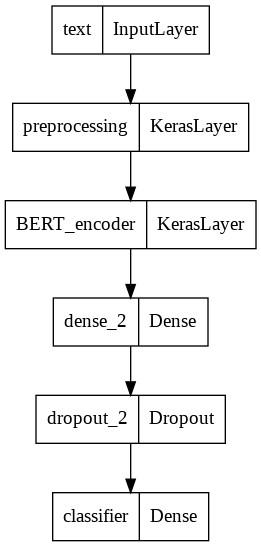

In [ ]:
tf.keras.utils.plot_model(utube_classifier_model)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("utube_bert_mlp",
                             monitor="val_TP",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

In [ ]:
earlystop = EarlyStopping(monitor = 'val_TP', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 2, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

In [ ]:
METRICS = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.TruePositives(name='TP')
]

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
utube_classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = utube_classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks = callbacks,
                               class_weight=class_weights
)

Training model with <tensorflow_hub.keras_layer.KerasLayer object at 0x7f83514e8990>
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


88/88 [==============================] - ETA: 0s - loss: 0.9673 - precision: 0.1067 - recall: 0.7539 - TP: 193.0000
Epoch 1: val_TP improved from -inf to 8.00000, saving model to utube_bert_mlp


88/88 [==============================] - 97s 889ms/step - loss: 0.9673 - precision: 0.1067 - recall: 0.7539 - TP: 193.0000 - val_loss: 0.3532 - val_precision: 0.4706 - val_recall: 0.2857 - val_TP: 8.0000
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 0.5888 - precision: 0.2022 - recall: 0.7070 - TP: 181.0000
Epoch 2: val_TP improved from 8.00000 to 22.00000, saving model to utube_bert_mlp


88/88 [==============================] - 72s 818ms/step - loss: 0.5888 - precision: 0.2022 - recall: 0.7070 - TP: 181.0000 - val_loss: 0.4323 - val_precision: 0.2588 - val_recall: 0.7857 - val_TP: 22.0000
Epoch 3/10
88/88 [==============================] - ETA: 0s - loss: 0.4848 - precision: 0.2857 - recall: 0.7500 - TP: 192.0000Restoring model weights from the end of the best epoch: 1.

Epoch 3: val_TP did not improve from 22.00000
88/88 [==============================] - 51s 581ms/step - loss: 0.4848 - precision: 0.2857 - recall: 0.7500 - TP: 192.0000 - val_loss: 0.4402 - val_precision: 0.2308 - val_recall: 0.5357 - val_TP: 15.0000
Epoch 3: early stopping


dict_keys(['loss', 'precision', 'recall', 'TP', 'val_loss', 'val_precision', 'val_recall', 'val_TP'])


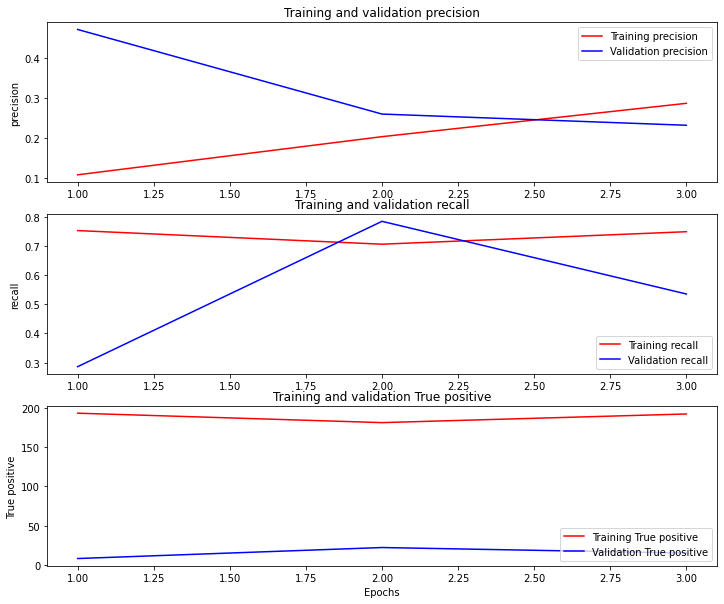

In [ ]:
history_dict = history.history
print(history_dict.keys())

TP = history_dict['TP']
val_TP = history_dict['val_TP']
precision = history_dict['precision']
val_precision = history_dict['val_precision']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

epochs = range(1, len(TP) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(3, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, precision, 'r', label='Training precision')
# b is for "solid blue line"
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
# plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()

plt.subplot(3, 1, 2)
# "bo" is for "blue dot"
plt.plot(epochs, recall, 'r', label='Training recall')
# b is for "solid blue line"
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
# plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(epochs, TP, 'r', label='Training True positive')
plt.plot(epochs, val_TP, 'b', label='Validation True positive')
plt.title('Training and validation True positive')
plt.xlabel('Epochs')
plt.ylabel('True positive')
plt.legend(loc='lower right')

In [ ]:
history_dict

{'TP': [193.0, 181.0, 192.0],
 'loss': [0.967303454875946, 0.5888069272041321, 0.4848234951496124],
 'precision': [0.10674779117107391, 0.2022346407175064, 0.2857142984867096],
 'recall': [0.75390625, 0.70703125, 0.75],
 'val_TP': [8.0, 22.0, 15.0],
 'val_loss': [0.3531535565853119, 0.432259202003479, 0.4402393400669098],
 'val_precision': [0.47058823704719543,
  0.25882354378700256,
  0.23076923191547394],
 'val_recall': [0.2857142984867096, 0.7857142686843872, 0.5357142686843872]}

In [ ]:
from keras.models import load_model

utube_classifier_model = tf.keras.models.load_model(
       ('utube_bert_mlp'),
       custom_objects={'KerasLayer': hub.KerasLayer,'AdamWeightDecay': optimizer}
)

###2.6.1 Results for MLP

####2.6.1.1 Doing predictions

In [ ]:
y_pred=utube_classifier_model.predict(test_ds)

11/11 [==============================] - 3s 215ms/step


In [ ]:
y_pred_mod=[]
for i in y_pred.tolist():
  for k in i:
    y_pred_mod.append(k)

In [ ]:
for i in range(len(y_pred_mod)):
  if y_pred_mod[i] <= float(0.5):
    y_pred_mod[i]= 0
  else:
    y_pred_mod[i]=1

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
result=precision_recall_fscore_support(y_test, y_pred_mod, average='macro')
print('Precision for BERT embeddings + MLP in Youtube Dataset is:',round(result[0],3))
print('Recall for BERT embeddings + MLP in Youtube Dataset is:',round(result[1],3))
print('macro F1 score for BERT embeddings + MLP in Youtube Dataset is:',round(result[2],3))

Precision for BERT embeddings + MLP in Youtube Dataset is: 0.501
Recall for BERT embeddings + MLP in Youtube Dataset is: 0.501
macro F1 score for BERT embeddings + MLP in Youtube Dataset is: 0.499


In [ ]:
from sklearn.metrics import f1_score
print("macro F1 score for BERT embeddings + MLP in Youtube dataset is:",f1_score(y_test, y_pred_mod, average='macro'))

macro F1 score for BERT embeddings + MLP in Youtube dataset is: 0.49939469099713585


###2.6.2 Confusion Matrix MLP

In [ ]:
def matrix_per(cf_matrix):
  group_percentages_list=[]
  k=cf_matrix.flatten()
  for i in range(0,len(cf_matrix.flatten())):
    if i == 0 or i == 1:
      group_percentages_list.append(k[i]/(k[0] + k[1]))
    else:
      group_percentages_list.append(k[i]/(k[2] + k[3]))
  return group_percentages_list

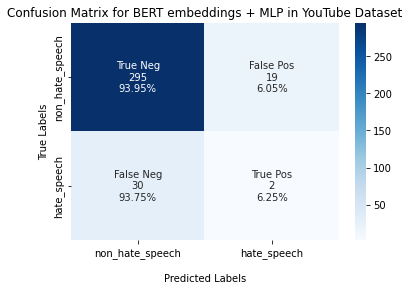

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf_matrix=confusion_matrix(y_test, y_pred_mod)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     matrix_per(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix for BERT embeddings + MLP in YouTube Dataset');
ax.set_xlabel('\nPredicted Labels')
ax.set_ylabel('True Labels');

ax.xaxis.set_ticklabels(['non_hate_speech','hate_speech'])
ax.yaxis.set_ticklabels(['non_hate_speech','hate_speech'])

## Display the visualization of the Confusion Matrix.
plt.show()

##2.7 BERT + BiLSTM

In [ ]:
from tensorflow.keras.layers import Bidirectional
from keras.layers import LSTM
def build_BiLstm_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    #net = outputs['pooled_output'] # [batch_size, 768].
    net = sequence_output = outputs["sequence_output"] # [batch_size, seq_length, 768]
    net=Bidirectional(LSTM(units=100,activation='tanh',return_sequences=False))(net)
      
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    
    net = tf.keras.layers.Dropout(0.1)(net)
#   net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.Dense(1, activation="sigmoid", name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

For the implementation with BiLSTM, I am using the sequence_output as input. It represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the text. I belive that this outputs saves positional information about the inputs, then it would make more sense to feed a BiLSTM layer.

In [ ]:
bi_classifier_model = build_BiLstm_classifier_model()
bert_raw_result = bi_classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.62263167]], shape=(1, 1), dtype=float32)


In [ ]:
text_test

[b'yeah i take commishion sorry i actully i kinda agree she could added frames made looka little better maybe creative changed little bit but need harsh give horse apple video creepy music good zorualuver taken news flash i dont give shit comment made it actually makes seem like prick i dont like homestuck i love it dd how do you not have more subbers wow art amazing it wont let watch phone copyrightedit kindle']

In [ ]:
bi_classifier_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

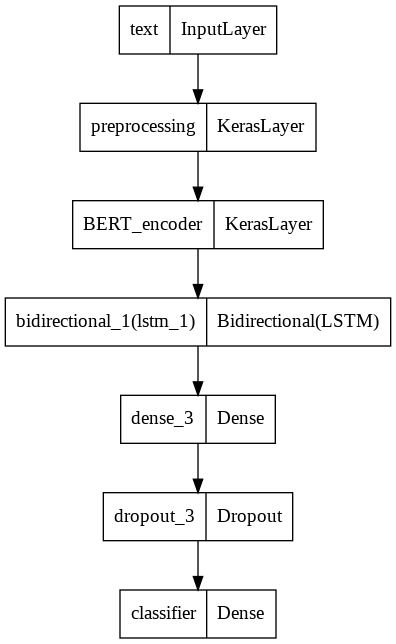

In [ ]:
tf.keras.utils.plot_model(bi_classifier_model)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("utube_bert_bi",
                             monitor="val_TP",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

In [ ]:
earlystop = EarlyStopping(monitor = 'val_TP', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 2, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

In [ ]:
METRICS = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.TruePositives(name='TP')
]

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
bi_classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history_bi = bi_classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks = callbacks,
                               class_weight=class_weights
)

Training model with <tensorflow_hub.keras_layer.KerasLayer object at 0x7f83514e8990>
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


88/88 [==============================] - ETA: 0s - loss: 0.6212 - precision: 0.1650 - recall: 0.5938 - TP: 152.0000
Epoch 1: val_TP improved from -inf to 15.00000, saving model to utube_bert_bi


88/88 [==============================] - 104s 1s/step - loss: 0.6212 - precision: 0.1650 - recall: 0.5938 - TP: 152.0000 - val_loss: 0.4706 - val_precision: 0.2381 - val_recall: 0.5357 - val_TP: 15.0000
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 0.5250 - precision: 0.2555 - recall: 0.6797 - TP: 174.0000
Epoch 2: val_TP did not improve from 15.00000
88/88 [==============================] - 53s 602ms/step - loss: 0.5250 - precision: 0.2555 - recall: 0.6797 - TP: 174.0000 - val_loss: 0.3896 - val_precision: 0.3250 - val_recall: 0.4643 - val_TP: 13.0000
Epoch 3/10
88/88 [==============================] - ETA: 0s - loss: 0.3925 - precision: 0.3969 - recall: 0.8047 - TP: 206.0000
Epoch 3: val_TP improved from 15.00000 to 23.00000, saving model to utube_bert_bi


88/88 [==============================] - 87s 994ms/step - loss: 0.3925 - precision: 0.3969 - recall: 0.8047 - TP: 206.0000 - val_loss: 0.8592 - val_precision: 0.1885 - val_recall: 0.8214 - val_TP: 23.0000
Epoch 4/10
88/88 [==============================] - ETA: 0s - loss: 0.3196 - precision: 0.5535 - recall: 0.8281 - TP: 212.0000
Epoch 4: val_TP did not improve from 23.00000
88/88 [==============================] - 53s 602ms/step - loss: 0.3196 - precision: 0.5535 - recall: 0.8281 - TP: 212.0000 - val_loss: 0.4530 - val_precision: 0.2667 - val_recall: 0.4286 - val_TP: 12.0000
Epoch 5/10
88/88 [==============================] - ETA: 0s - loss: 0.2422 - precision: 0.7019 - recall: 0.8828 - TP: 226.0000
Epoch 5: val_TP did not improve from 23.00000
88/88 [==============================] - 53s 601ms/step - loss: 0.2422 - precision: 0.7019 - recall: 0.8828 - TP: 226.0000 - val_loss: 0.3681 - val_precision: 0.3889 - val_recall: 0.2500 - val_TP: 7.0000
Epoch 6/10
88/88 [======================

dict_keys(['loss', 'precision', 'recall', 'TP', 'val_loss', 'val_precision', 'val_recall', 'val_TP'])


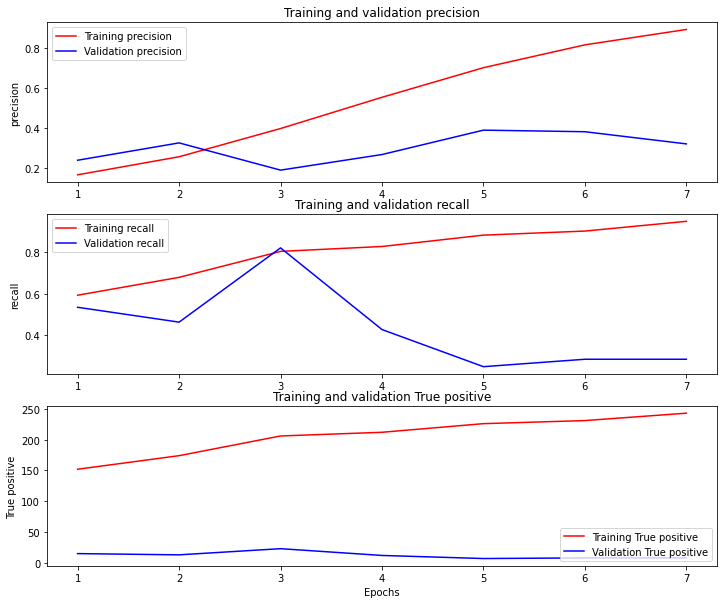

In [ ]:
history_dict = history_bi.history
print(history_dict.keys())

TP = history_dict['TP']
val_TP = history_dict['val_TP']
# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
precision = history_dict['precision']
val_precision = history_dict['val_precision']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

epochs = range(1, len(TP) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(3, 1, 1)
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
# plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()

plt.subplot(3, 1, 2)
# "bo" is for "blue dot"
plt.plot(epochs, recall, 'r', label='Training recall')
# b is for "solid blue line"
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
#plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(epochs, TP, 'r', label='Training True positive')
plt.plot(epochs, val_TP, 'b', label='Validation True positive')
plt.title('Training and validation True positive')
plt.xlabel('Epochs')
plt.ylabel('True positive')
plt.legend(loc='lower right')

In [ ]:
history_dict

{'TP': [152.0, 174.0, 206.0, 212.0, 226.0, 231.0, 243.0],
 'loss': [0.6211796402931213,
  0.5250285267829895,
  0.39246711134910583,
  0.3196370601654053,
  0.24220260977745056,
  0.20227843523025513,
  0.12215665727853775],
 'precision': [0.16503800451755524,
  0.25550660490989685,
  0.3969171345233917,
  0.5535247921943665,
  0.7018633484840393,
  0.8162544369697571,
  0.8933823704719543],
 'recall': [0.59375,
  0.6796875,
  0.8046875,
  0.828125,
  0.8828125,
  0.90234375,
  0.94921875],
 'val_TP': [15.0, 13.0, 23.0, 12.0, 7.0, 8.0, 8.0],
 'val_loss': [0.4706301987171173,
  0.38959312438964844,
  0.8592303395271301,
  0.453043133020401,
  0.36806580424308777,
  0.38885077834129333,
  0.5273351073265076],
 'val_precision': [0.2380952388048172,
  0.32499998807907104,
  0.18852458894252777,
  0.2666666805744171,
  0.3888888955116272,
  0.380952388048172,
  0.3199999928474426],
 'val_recall': [0.5357142686843872,
  0.4642857015132904,
  0.8214285969734192,
  0.4285714328289032,
  0.25,


In [ ]:
from keras.models import load_model

bi_classifier_model = tf.keras.models.load_model(
       ('utube_bert_bi'),
       custom_objects={'KerasLayer': hub.KerasLayer,'AdamWeightDecay': optimizer}
)

###2.7.1 Results for BiLSTM

####2.7.1.1 Doing predictions

In [ ]:
y_pred=bi_classifier_model.predict(test_ds)

11/11 [==============================] - 4s 207ms/step


In [ ]:
y_pred_mod=[]
for i in y_pred.tolist():
  for k in i:
    y_pred_mod.append(k)

In [ ]:
for i in range(len(y_pred_mod)):
  if y_pred_mod[i] <= float(0.5):
    y_pred_mod[i]= 0
  else:
    y_pred_mod[i]=1

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
result=precision_recall_fscore_support(y_test, y_pred_mod, average='macro')
print('Precision for BERT embeddings + BiLSTM in Youtube Dataset is:',round(result[0],3))
print('Recall for BERT embeddings + BiLSTM in Youtube Dataset is:',round(result[1],3))
print('macro F1 score for BERT embeddings + BiLSTM in Youtube Dataset is:',round(result[2],3))

Precision for BERT embeddings + BiLSTM in Youtube Dataset is: 0.474
Recall for BERT embeddings + BiLSTM in Youtube Dataset is: 0.481
macro F1 score for BERT embeddings + BiLSTM in Youtube Dataset is: 0.477


In [ ]:
from sklearn.metrics import f1_score
print("macro F1 score for BERT embeddings + BiLSTM in YouTube dataset is:",f1_score(y_test, y_pred_mod, average='macro'))

macro F1 score for BERT embeddings + BiLSTM in YouTube dataset is: 0.476580562294848


###2.7.2 Confusion Matrix BiLSTM

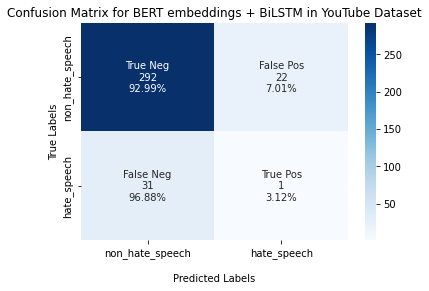

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf_matrix=confusion_matrix(y_test, y_pred_mod)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     matrix_per(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix for BERT embeddings + BiLSTM in YouTube Dataset');
ax.set_xlabel('\nPredicted Labels')
ax.set_ylabel('True Labels');

ax.xaxis.set_ticklabels(['non_hate_speech','hate_speech'])
ax.yaxis.set_ticklabels(['non_hate_speech','hate_speech'])

## Display the visualization of the Confusion Matrix.
plt.show()

# 3.Twitter Dataset

###3.1 Installing dependencies and importing packages

In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt    

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

     |████████████████████████████████| 4.6 MB 2.6 MB/s 
     |████████████████████████████████| 511.7 MB 6.1 kB/s 
     |████████████████████████████████| 438 kB 65.1 MB/s 
     |████████████████████████████████| 1.6 MB 51.7 MB/s 
     |████████████████████████████████| 5.8 MB 60.1 MB/s 


In [ ]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.1 MB 3.3 MB/s 
     |████████████████████████████████| 238 kB 54.4 MB/s 
     |████████████████████████████████| 116 kB 35.5 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 352 kB 49.9 MB/s 
     |████████████████████████████████| 1.2 MB 4.6 MB/s 
     |████████████████████████████████| 636 kB 45.6 MB/s 
     |████████████████████████████████| 99 kB 4.6 MB/s 
     |████████████████████████████████| 1.1 MB 15.6 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 3.1 MB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 
     |████████████████████████████████| 6.6 MB 57.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

np.set_printoptions(suppress=True)
print(tf.__version__)

import shutil

from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

2.9.1


##3.2 Reading and preparing the dataset

In [ ]:
df_tw=pd.read_csv('twitter_clean.csv')

In [ ]:
df_tw

,Text,Label,Text_clean,category
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read context no change meaning the history i...,non_hate_speech
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now idiots claim people tried stop becoming te...,non_hate_speech
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,call sexist i go auto place i rather talk guy,hate_speech
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows example mohammed quran exactly,hate_speech
4,#mkr No No No No No No,0.0,mkr no no no no no no,non_hate_speech
...,...,...,...,...
16819,"Feeling so sorry for the girls, they should be...",0.0,feeling sorry girls safe kat andre going home mkr,non_hate_speech
16820,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes happy ok well i never e...,non_hate_speech
16821,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,deconstructed lemon tart please go one season ...,non_hate_speech
16822,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you stupid talk blocked,non_hate_speech


In [ ]:
# Grouping data by label
df_tw.groupby('Label').count()

,Text,Text_clean,category
Label,,,
0.0,11477,11305,11477
1.0,5347,5345,5347


This is an unbalanced dataset. 

In [ ]:
df_tw['category'].value_counts()

non_hate_speech    11477
hate_speech         5347
Name: category, dtype: int64

###3.2.1 Splitting the data between train, validation and test sets:

In [ ]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df_tw.index.values,
    df_tw.Label.values,
    test_size=0.10,
    random_state=42,
    stratify=df_tw.Label.values,    
)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    df_tw.loc[X_train_].index.values,
    df_tw.loc[X_train_].Label.values,
    test_size=0.10,
    random_state=42,
    stratify=df_tw.loc[X_train_].Label.values,  
)

In [ ]:
df_tw['data_type'] = ['not_set']*df_tw.shape[0]
df_tw.loc[X_train, 'data_type'] = 'train'
df_tw.loc[X_val, 'data_type'] = 'val'
df_tw.loc[X_test, 'data_type'] = 'test'

In [ ]:
df_tw.groupby(['category', 'Label', 'data_type']).count()

Text  Text_clean
category        Label data_type                  
hate_speech     1.0   test        535         535
                      train      4331        4329
                      val         481         481
non_hate_speech 0.0   test       1148        1126
                      train      9295        9158
                      val        1034        1021

In [ ]:
df_train = df_tw.loc[df_tw["data_type"]=="train"]
df_train.head(5)

,Text,Label,Text_clean,category,data_type
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read context no change meaning the history i...,non_hate_speech,train
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,call sexist i go auto place i rather talk guy,hate_speech,train
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows example mohammed quran exactly,hate_speech,train
4,#mkr No No No No No No,0.0,mkr no no no no no no,non_hate_speech,train
5,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...,0.0,saudi preacher raped tortured five year old da...,non_hate_speech,train


In [ ]:
df_val = df_tw.loc[df_tw["data_type"]=="val"]
df_val.head(5)

,Text,Label,Text_clean,category,data_type
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now idiots claim people tried stop becoming te...,non_hate_speech,val
10,@dllvllHllvllb @hyperion5182 @PolitiBunny @The...,0.0,autoblocker run blockbot blocking manually,non_hate_speech,val
11,@SirajZarook @OdiniaInvictus @BilalIGhumman @I...,1.0,a good muslim good despite bad religion,hate_speech,val
18,Juxtaposition. http://t.co/11cqlxSUsf,0.0,juxtaposition,non_hate_speech,val
32,@chilblane yay. i went last year and had to ma...,0.0,yay went last year make new friends hate makin...,non_hate_speech,val


In [ ]:
df_test = df_tw.loc[df_tw["data_type"]=="test"]
df_test.head(5)

,Text,Label,Text_clean,category,data_type
6,RT @Millhouse66 @Maureen_JS nooo not sexist bu...,1.0,_js nooo sexist women bad drivers,hate_speech,test
7,Going to make some pancakes.....Don't hve any ...,0.0,going make pancakes don hve strawberries i hve...,non_hate_speech,test
8,RT @ahtweet: @freebsdgirl How dare you have fe...,0.0,how dare feelings fantastic way dehumanize som...,non_hate_speech,test
15,@Israelites234 @jacquard612 @Loveussr ROFLMAO....,0.0,roflmao the putin delusion factory running ful...,non_hate_speech,test
30,RT @TheMeninism: guys who sell drugs get more ...,1.0,guys sell drugs get girls guys degrees says wo...,hate_speech,test


In [ ]:
df_tw.dtypes

Text           object
Label         float64
Text_clean     object
category       object
data_type      object
dtype: object

##3.3 Build TensorFlow input 

In [ ]:
df_train['Text_clean']=df_train['Text_clean'].astype('str')
df_val['Text_clean']=df_val['Text_clean'].astype('str')
df_test['Text_clean']=df_test['Text_clean'].astype('str')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.Text_clean.values, df_train.Label.values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.Text_clean.values, df_val.Label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.Text_clean.values, df_test.Label.values))

In [ ]:
train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
for feat, targ in train_ds.take(1):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [b'not sexist woman presenting motd fuck get gary back'
 b'do grovel ground fear people personal relationship'
 b'exciting times mkr 67 teams left'
 b'in words former contestant katie nikki need calm farm mkr'
 b'i think pretty telling 14 year old boys twitter sound exactly like grown men i use term loosely'
 b'so never used ice cream maker mkr'
 b'_games hey toss info pass chain enforcer type people would appreciated'
 b'vicky celine team sudden death no surprise although would nice kat and'
 b'nowhere yet secure funding hiring'
 b'well done mkr keeping scum show hope kat andre end poisoning fuckers'
 b'they the basin pittwater across palm beach nsw mkr'
 b'oops meant katie bigthighs mkr'
 b'sorry i listened youtube propaganda videos people suggest i time anything else'
 b'i think daesh rejected embarrassment but follow quran sunnah letter'
 b'escaped syrian child soldier don join isis'
 b'_d_almeida im sexist amazing woman knows cook lovrmesomefood'
 b'mkr2016 returns 2020 

##3.4 Loading models from TensorFlow Hub

In [ ]:
tfhub_handle_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3",trainable=True)
tfhub_handle_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1")


print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model selected: {tfhub_handle_preprocess}')


BERT model selected           : <tensorflow_hub.keras_layer.KerasLayer object at 0x7fc1201ce550>
Preprocess model selected: <tensorflow_hub.keras_layer.KerasLayer object at 0x7fc1201ceb90>


I've chosen "bert_en_uncased_L-12_H-768_A-12"

This TF Hub model uses the implementation of BERT from the TensorFlow Models repository on GitHub at tensorflow/models/official/nlp/bert. It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads.

###3.4.1 The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models, which implements this transformation using TF ops from the TF.text library. Hence, It is not necessary to run pure Python code outside the TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which can be read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    tweet = text_batch.numpy()[i]
    print(f'Tweet: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

text_test = ['this is such an amazing movie!']
text_test = [tweet]


text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Tweet: b'hey guys mras found oh noes whatever i damsel distress oh gosh plz stop hapless victim'
Label : 0.0
Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  4931  4364  2720  3022  2179  2821  2053  2229  3649  1045 17278]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: <tensorflow_hub.keras_layer.KerasLayer object at 0x7fc1201ce550>
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.7959782  -0.4505574  -0.6885508   0.68486863  0.4291326  -0.09543748
  0.8332503   0.31531605 -0.53359485 -0.9999569   0.07913192  0.80009675]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.19702244  0.15311857  0.13227914 ... -0.51522356  0.27253234
   0.3311263 ]
 [ 0.23076424  0.32365555  1.256163   ... -0.32148838  0.68886244
  -0.537227  ]
 [ 0.20816123  0.5564159   0.7905645  ... -0.46496388  0.5234574
  -0.94601196]
 ...
 [-0.02548136  0.25272825  0.5611321  ...  0.08106738  0.05295114
  -0.3721489 ]
 [-0.45563158  0.5787033   1.0358783  ... -0.8256416   0.01806622
  -0.07885936]
 [-0.3651393   0.46996772  1.4624885  ... -0.65515506  0.6627224
  -0.02304045]]


##3.5 Techniques to deal with unbalanced data

###3.5.1 Calculate class weights

Since our datset is higly imbalanced there are high chances our model will be biased toward majority class. Now since I want my model to concentrate more on minority class which I can achieve by passing more weights to minority class.


In [ ]:
df_tw

,Text,Label,Text_clean,category,data_type
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read context no change meaning the history i...,non_hate_speech,train
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now idiots claim people tried stop becoming te...,non_hate_speech,val
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,call sexist i go auto place i rather talk guy,hate_speech,train
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows example mohammed quran exactly,hate_speech,train
4,#mkr No No No No No No,0.0,mkr no no no no no no,non_hate_speech,train
...,...,...,...,...,...
16819,"Feeling so sorry for the girls, they should be...",0.0,feeling sorry girls safe kat andre going home mkr,non_hate_speech,train
16820,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes happy ok well i never e...,non_hate_speech,train
16821,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,deconstructed lemon tart please go one season ...,non_hate_speech,val
16822,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you stupid talk blocked,non_hate_speech,train


In [ ]:
non_hate_speech, hate_speech = np.bincount(df_tw['Label'])
total = hate_speech + non_hate_speech
print('Examples:\n    Total: {}\n    non_hate_speech: {} ({:.2f}% of total)\n'.format(
    total, non_hate_speech, 100 *  non_hate_speech / total))
print('Examples:\n    Total: {}\n    hate_speech: {} ({:.2f}% of total)\n'.format(
    total, hate_speech, 100 * hate_speech / total))


Examples:
    Total: 16824
    non_hate_speech: 11477 (68.22% of total)

Examples:
    Total: 16824
    hate_speech: 5347 (31.78% of total)



In [ ]:
weight_for_0 = (1 / non_hate_speech)*(total)/2.0 
weight_for_1 = (1 / hate_speech)*(total)/2.0


class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.73
Weight for class 1: 1.57


In [ ]:
class_weights

{0: 0.732944149167901, 1: 1.5732186272676267}

###3.5.2 Set the correct initial bias


In [ ]:
initial_output_bias = np.array([3.938462])
initial_output_bias 

array([3.938462])

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.5132725 , -0.88845736, ..., -0.7474887 ,
        -0.75314736,  0.91964495],
       [-0.8720836 , -0.50543964, -0.94446665, ..., -0.858475  ,
        -0.7174535 ,  0.88082975]], dtype=float32)>

##3.6 BERT + MLP


I am going to create a simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

In [ ]:
def build_classifier_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
       
        
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(1, activation="sigmoid", name='classifier', bias_initializer=output_bias)(net)
    
    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model(output_bias=initial_output_bias)
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.71855956]], shape=(1, 1), dtype=float32)


In [ ]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

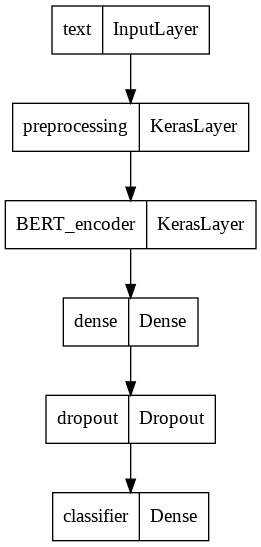

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("twitter_bert_mlp",
                             monitor="val_TP",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

In [ ]:
earlystop = EarlyStopping(monitor = 'val_TP', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 2, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

In [ ]:
METRICS = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.TruePositives(name='TP')
]

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [ ]:
df_tw.groupby(['category', 'Label', 'data_type']).count()

Text  Text_clean
category        Label data_type                  
hate_speech     1.0   test        535         535
                      train      4331        4329
                      val         481         481
non_hate_speech 0.0   test       1148        1126
                      train      9295        9158
                      val        1034        1021

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks = callbacks,
                               class_weight=class_weights
)

Training model with <tensorflow_hub.keras_layer.KerasLayer object at 0x7fc1201ce550>
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


426/426 [==============================] - ETA: 0s - loss: 0.6204 - precision: 0.5054 - recall: 0.7492 - TP: 3245.0000
Epoch 1: val_TP improved from -inf to 395.00000, saving model to twitter_bert_mlp


426/426 [==============================] - 300s 631ms/step - loss: 0.6204 - precision: 0.5054 - recall: 0.7492 - TP: 3245.0000 - val_loss: 0.4274 - val_precision: 0.6775 - val_recall: 0.8212 - val_TP: 395.0000
Epoch 2/10
426/426 [==============================] - ETA: 0s - loss: 0.3880 - precision: 0.7147 - recall: 0.8220 - TP: 3560.0000
Epoch 2: val_TP did not improve from 395.00000
426/426 [==============================] - 243s 571ms/step - loss: 0.3880 - precision: 0.7147 - recall: 0.8220 - TP: 3560.0000 - val_loss: 0.3823 - val_precision: 0.7510 - val_recall: 0.7775 - val_TP: 374.0000
Epoch 3/10
426/426 [==============================] - ETA: 0s - loss: 0.2608 - precision: 0.8042 - recall: 0.9009 - TP: 3902.0000
Epoch 3: val_TP did not improve from 395.00000
426/426 [==============================] - 243s 570ms/step - loss: 0.2608 - precision: 0.8042 - recall: 0.9009 - TP: 3902.0000 - val_loss: 0.4297 - val_precision: 0.6735 - val_recall: 0.8191 - val_TP: 394.0000
Epoch 4/10
426/4

dict_keys(['loss', 'precision', 'recall', 'TP', 'val_loss', 'val_precision', 'val_recall', 'val_TP'])


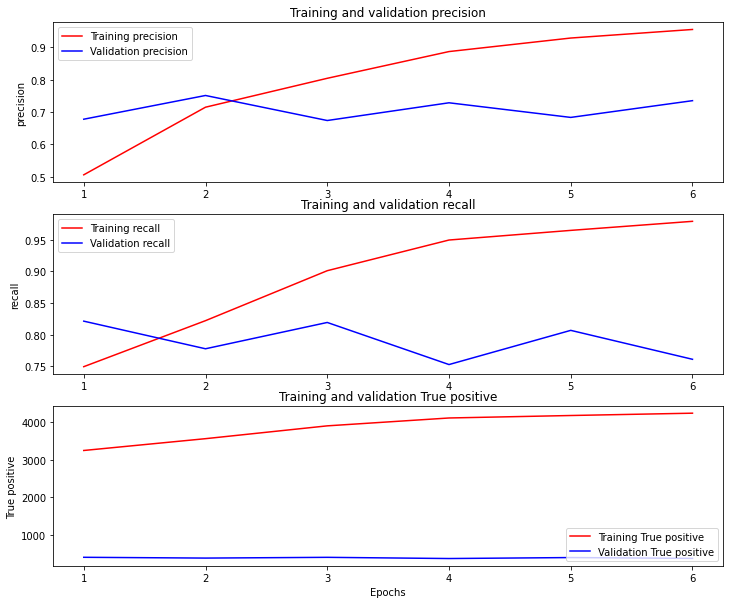

In [ ]:
history_dict = history.history
print(history_dict.keys())

TP = history_dict['TP']
val_TP = history_dict['val_TP']
# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
precision = history_dict['precision']
val_precision = history_dict['val_precision']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

epochs = range(1, len(TP) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(3, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, precision, 'r', label='Training precision')
# b is for "solid blue line"
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
# plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()

plt.subplot(3, 1, 2)
# "bo" is for "blue dot"
plt.plot(epochs, recall, 'r', label='Training recall')
# b is for "solid blue line"
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
# plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(epochs, TP, 'r', label='Training True positive')
plt.plot(epochs, val_TP, 'b', label='Validation True positive')
plt.title('Training and validation True positive')
plt.xlabel('Epochs')
plt.ylabel('True positive')
plt.legend(loc='lower right')

In [ ]:
history_dict

{'TP': [3245.0, 3560.0, 3902.0, 4112.0, 4178.0, 4240.0],
 'loss': [0.6203585267066956,
  0.3880145847797394,
  0.2607695460319519,
  0.16204531490802765,
  0.11212904751300812,
  0.07854334264993668],
 'precision': [0.5053730010986328,
  0.7147158980369568,
  0.8042044639587402,
  0.8869715332984924,
  0.9288572669029236,
  0.9553853273391724],
 'recall': [0.7492495775222778,
  0.8219810724258423,
  0.9009466767311096,
  0.9494343400001526,
  0.9646732807159424,
  0.9789887070655823],
 'val_TP': [395.0, 374.0, 394.0, 362.0, 388.0, 366.0],
 'val_loss': [0.42736780643463135,
  0.3823048770427704,
  0.42967480421066284,
  0.5593990087509155,
  0.7382084131240845,
  0.735034167766571],
 'val_precision': [0.6775299906730652,
  0.7510040402412415,
  0.6735042929649353,
  0.7283702492713928,
  0.6830986142158508,
  0.7349397540092468],
 'val_recall': [0.8212057948112488,
  0.777546763420105,
  0.8191268444061279,
  0.752598762512207,
  0.8066527843475342,
  0.7609147429466248]}

In [ ]:
from keras.models import load_model

classifier_model = tf.keras.models.load_model(
       ('twitter_bert_mlp'),
       custom_objects={'KerasLayer': hub.KerasLayer,'AdamWeightDecay': optimizer}
)

###3.6.1 Results for MLP

####3.6.1.1 Doing predictions

In [ ]:
y_pred=classifier_model.predict(test_ds)

53/53 [==============================] - 12s 210ms/step


In [ ]:
y_pred_mod=[]
for i in y_pred.tolist():
  for k in i:
    y_pred_mod.append(k)

In [ ]:
for i in range(len(y_pred_mod)):
  if y_pred_mod[i] <= float(0.5):
    y_pred_mod[i]= 0
  else:
    y_pred_mod[i]=1

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
result=precision_recall_fscore_support(y_test, y_pred_mod, average='macro')
print('Precision for BERT embeddings + MLP in Twitter Dataset is:',round(result[0],3))
print('Recall for BERT embeddings + MLP in Twitter Dataset is:',round(result[1],3))
print('macro F1 score for BERT embeddings + MLP in Twitter Dataset is:',round(result[2],3))

Precision for BERT embeddings + MLP in Twitter Dataset is: 0.506
Recall for BERT embeddings + MLP in Twitter Dataset is: 0.506
macro F1 score for BERT embeddings + MLP in Twitter Dataset is: 0.506


In [ ]:
from sklearn.metrics import f1_score
print("macro F1 score for BERT embeddings + MLP in Twitter Dataset is:",f1_score(y_test, y_pred_mod, average='macro'))

macro F1 score for BERT embeddings + MLP in Twitter Dataset is: 0.506369007575536


###3.6.2 Confusion Matrix MLP

In [ ]:
def matrix_per(cf_matrix):
  group_percentages_list=[]
  k=cf_matrix.flatten()
  for i in range(0,len(cf_matrix.flatten())):
    if i == 0 or i == 1:
      group_percentages_list.append(k[i]/(k[0] + k[1]))
    else:
      group_percentages_list.append(k[i]/(k[2] + k[3]))
  return group_percentages_list

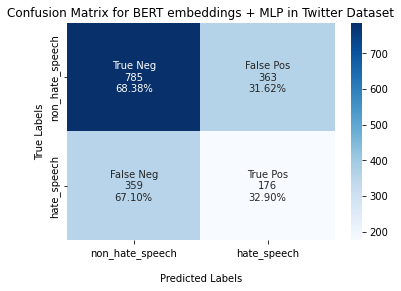

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf_matrix=confusion_matrix(y_test, y_pred_mod)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     matrix_per(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix for BERT embeddings + MLP in Twitter Dataset');
ax.set_xlabel('\nPredicted Labels')
ax.set_ylabel('True Labels');

ax.xaxis.set_ticklabels(['non_hate_speech','hate_speech'])
ax.yaxis.set_ticklabels(['non_hate_speech','hate_speech'])

## Display the visualization of the Confusion Matrix.
plt.show()

##3.7 BERT + BiLSTM

In [ ]:
from tensorflow.keras.layers import Bidirectional
from keras.layers import LSTM
def build_BiLstm_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    #net = outputs['pooled_output'] # [batch_size, 768].
    net = sequence_output = outputs["sequence_output"] # [batch_size, seq_length, 768]
    net=Bidirectional(LSTM(units=100,activation='tanh',return_sequences=False))(net)
      
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    
    net = tf.keras.layers.Dropout(0.1)(net)
#   net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.Dense(1, activation="sigmoid", name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

For the implementation with BiLSTM, I am using the sequence_output as input. It represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the text. I belive that this outputs saves positional information about the inputs, then it would make more sense to feed a BiLSTM layer.

In [ ]:
bi_classifier_model = build_BiLstm_classifier_model()
bert_raw_result = bi_classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6313716]], shape=(1, 1), dtype=float32)


In [ ]:
text_test

[b'hey guys mras found oh noes whatever i damsel distress oh gosh plz stop hapless victim']

In [ ]:
bi_classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

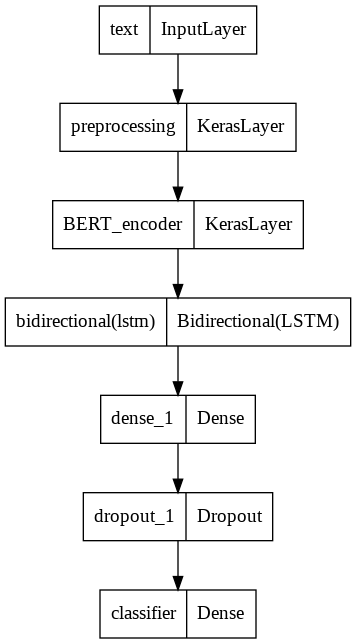

In [ ]:
tf.keras.utils.plot_model(bi_classifier_model)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("twitter_bert_bi",
                             monitor="val_TP",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

In [ ]:
earlystop = EarlyStopping(monitor = 'val_TP', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 2, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

In [ ]:
METRICS = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.TruePositives(name='TP')
]

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
bi_classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

In [ ]:
df_tw.groupby(['category', 'Label', 'data_type']).count()

Text  Text_clean
category        Label data_type                  
hate_speech     1.0   test        535         535
                      train      4331        4329
                      val         481         481
non_hate_speech 0.0   test       1148        1126
                      train      9295        9158
                      val        1034        1021

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history_bi = bi_classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks = callbacks,
                               class_weight=class_weights
)

Training model with <tensorflow_hub.keras_layer.KerasLayer object at 0x7fc1201ce550>
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


426/426 [==============================] - ETA: 0s - loss: 0.2291 - precision: 0.7910 - recall: 0.9531 - TP: 4128.0000
Epoch 1: val_TP improved from -inf to 339.00000, saving model to twitter_bert_bi


426/426 [==============================] - 302s 679ms/step - loss: 0.2291 - precision: 0.7910 - recall: 0.9531 - TP: 4128.0000 - val_loss: 0.5367 - val_precision: 0.7670 - val_recall: 0.7048 - val_TP: 339.0000
Epoch 2/10
426/426 [==============================] - ETA: 0s - loss: 0.1198 - precision: 0.9260 - recall: 0.9626 - TP: 4169.0000
Epoch 2: val_TP improved from 339.00000 to 359.00000, saving model to twitter_bert_bi


426/426 [==============================] - 287s 673ms/step - loss: 0.1198 - precision: 0.9260 - recall: 0.9626 - TP: 4169.0000 - val_loss: 0.6112 - val_precision: 0.7327 - val_recall: 0.7464 - val_TP: 359.0000
Epoch 3/10
426/426 [==============================] - ETA: 0s - loss: 0.0885 - precision: 0.9562 - recall: 0.9718 - TP: 4209.0000Restoring model weights from the end of the best epoch: 1.

Epoch 3: val_TP improved from 359.00000 to 410.00000, saving model to twitter_bert_bi


426/426 [==============================] - 287s 673ms/step - loss: 0.0885 - precision: 0.9562 - recall: 0.9718 - TP: 4209.0000 - val_loss: 0.8950 - val_precision: 0.6298 - val_recall: 0.8524 - val_TP: 410.0000
Epoch 3: early stopping


dict_keys(['loss', 'precision', 'recall', 'TP', 'val_loss', 'val_precision', 'val_recall', 'val_TP'])


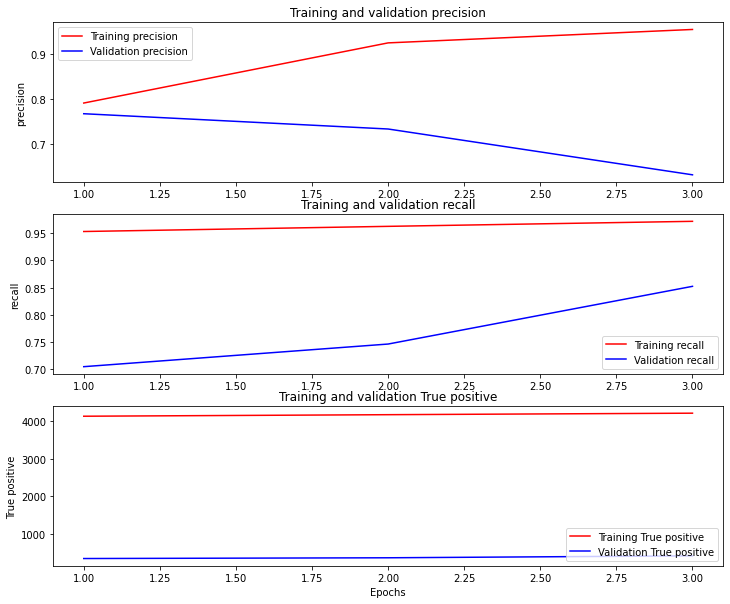

In [ ]:
history_dict = history_bi.history
print(history_dict.keys())

TP = history_dict['TP']
val_TP = history_dict['val_TP']
precision = history_dict['precision']
val_precision = history_dict['val_precision']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

epochs = range(1, len(TP) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(3, 1, 1)
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.ylabel('precision')
plt.legend()

plt.subplot(3, 1, 2)
# "bo" is for "blue dot"
plt.plot(epochs, recall, 'r', label='Training recall')
# b is for "solid blue line"
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
#plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(epochs, TP, 'r', label='Training True positive')
plt.plot(epochs, val_TP, 'b', label='Validation True positive')
plt.title('Training and validation True positive')
plt.xlabel('Epochs')
plt.ylabel('True positive')
plt.legend(loc='lower right')

In [ ]:
history_dict

{'TP': [4128.0, 4169.0, 4209.0],
 'loss': [0.22907602787017822, 0.11978249996900558, 0.08851177245378494],
 'precision': [0.7909561395645142, 0.9260329008102417, 0.956156313419342],
 'recall': [0.9531286358833313, 0.9625952243804932, 0.9718309640884399],
 'val_TP': [339.0, 359.0, 410.0],
 'val_loss': [0.536689281463623, 0.61117023229599, 0.8950422406196594],
 'val_precision': [0.766968309879303, 0.7326530814170837, 0.6298003196716309],
 'val_recall': [0.704781711101532, 0.7463617324829102, 0.8523908257484436]}

In [ ]:
from keras.models import load_model

bi_classifier_model = tf.keras.models.load_model(
       ('twitter_bert_bi'),
       custom_objects={'KerasLayer': hub.KerasLayer,'AdamWeightDecay': optimizer}
)

###3.7.1 Results for BiLSTM

####3.7.1.1 Doing predictions

In [ ]:
y_pred=bi_classifier_model.predict(test_ds)

53/53 [==============================] - 17s 278ms/step


In [ ]:
y_pred_mod=[]
for i in y_pred.tolist():
  for k in i:
    y_pred_mod.append(k)

In [ ]:
for i in range(len(y_pred_mod)):
  if y_pred_mod[i] <= float(0.5):
    y_pred_mod[i]= 0
  else:
    y_pred_mod[i]=1

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
result=precision_recall_fscore_support(y_test, y_pred_mod, average='macro')
print('Precision for BERT embeddings + BiLSTM in Twitter Dataset is:',round(result[0],3))
print('Recall for BERT embeddings + BiLSTM in Twitter Dataset is:',round(result[1],3))
print('macro F1 score for BERT embeddings + BiLSTM in Twitter Dataset is:',round(result[2],3))

Precision for BERT embeddings + BiLSTM in Twitter Dataset is: 0.493
Recall for BERT embeddings + BiLSTM in Twitter Dataset is: 0.493
macro F1 score for BERT embeddings + BiLSTM in Twitter Dataset is: 0.493


In [ ]:
from sklearn.metrics import f1_score
print("macro F1 score for BERT embeddings + BiLSTM in Twitter Dataset is:",f1_score(y_test, y_pred_mod, average='macro'))

macro F1 score for BERT embeddings + BiLSTM in Twitter Dataset is: 0.4926214452040961


###3.7.2 Confusion Matrix BiLSTM

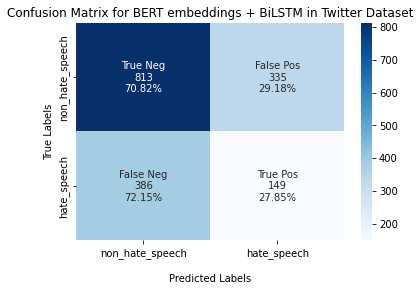

In [ ]:
cf_matrix=confusion_matrix(y_test, y_pred_mod)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     matrix_per(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix for BERT embeddings + BiLSTM in Twitter Dataset');
ax.set_xlabel('\nPredicted Labels')
ax.set_ylabel('True Labels');

ax.xaxis.set_ticklabels(['non_hate_speech','hate_speech'])
ax.yaxis.set_ticklabels(['non_hate_speech','hate_speech'])

## Display the visualization of the Confusion Matrix.
plt.show()